<a href="https://colab.research.google.com/github/Mrunali0412/Deep-DPD-modelling-for-PA-Linearization/blob/main/Re_Trainning_PA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Deep Learning DPD for PA Linearization

Training NN-PA on 22288 samples...
Epoch [10/100], Train Loss: 0.003060, Val Loss: 0.000710
Epoch [20/100], Train Loss: 0.002321, Val Loss: 0.000284
Epoch [30/100], Train Loss: 0.002009, Val Loss: 0.000463
Epoch [40/100], Train Loss: 0.001841, Val Loss: 0.000159
Epoch [50/100], Train Loss: 0.001724, Val Loss: 0.000242
Epoch [60/100], Train Loss: 0.001659, Val Loss: 0.000204
Epoch [70/100], Train Loss: 0.001632, Val Loss: 0.000143
Epoch [80/100], Train Loss: 0.001584, Val Loss: 0.000180
Epoch [90/100], Train Loss: 0.001567, Val Loss: 0.000186
Epoch [100/100], Train Loss: 0.001561, Val Loss: 0.000187
NN-PA training complete.
NN-PA NMSE vs real PA: -29.59 dB

--- Performance Physical PA ---
NMSE: -10.58 dB
EVM: 26.47 %
ACPR: -43.01 dB

--- Performance NN-PA ---
NMSE: -11.36 dB
EVM: 24.17 %
ACPR: -39.04 dB

[3] Training Deep Learning DPD...

Training Deep DPD Model...
Architecture: Input(12) → Hidden[256, 128, 64, 32] → Output(2)
Tr

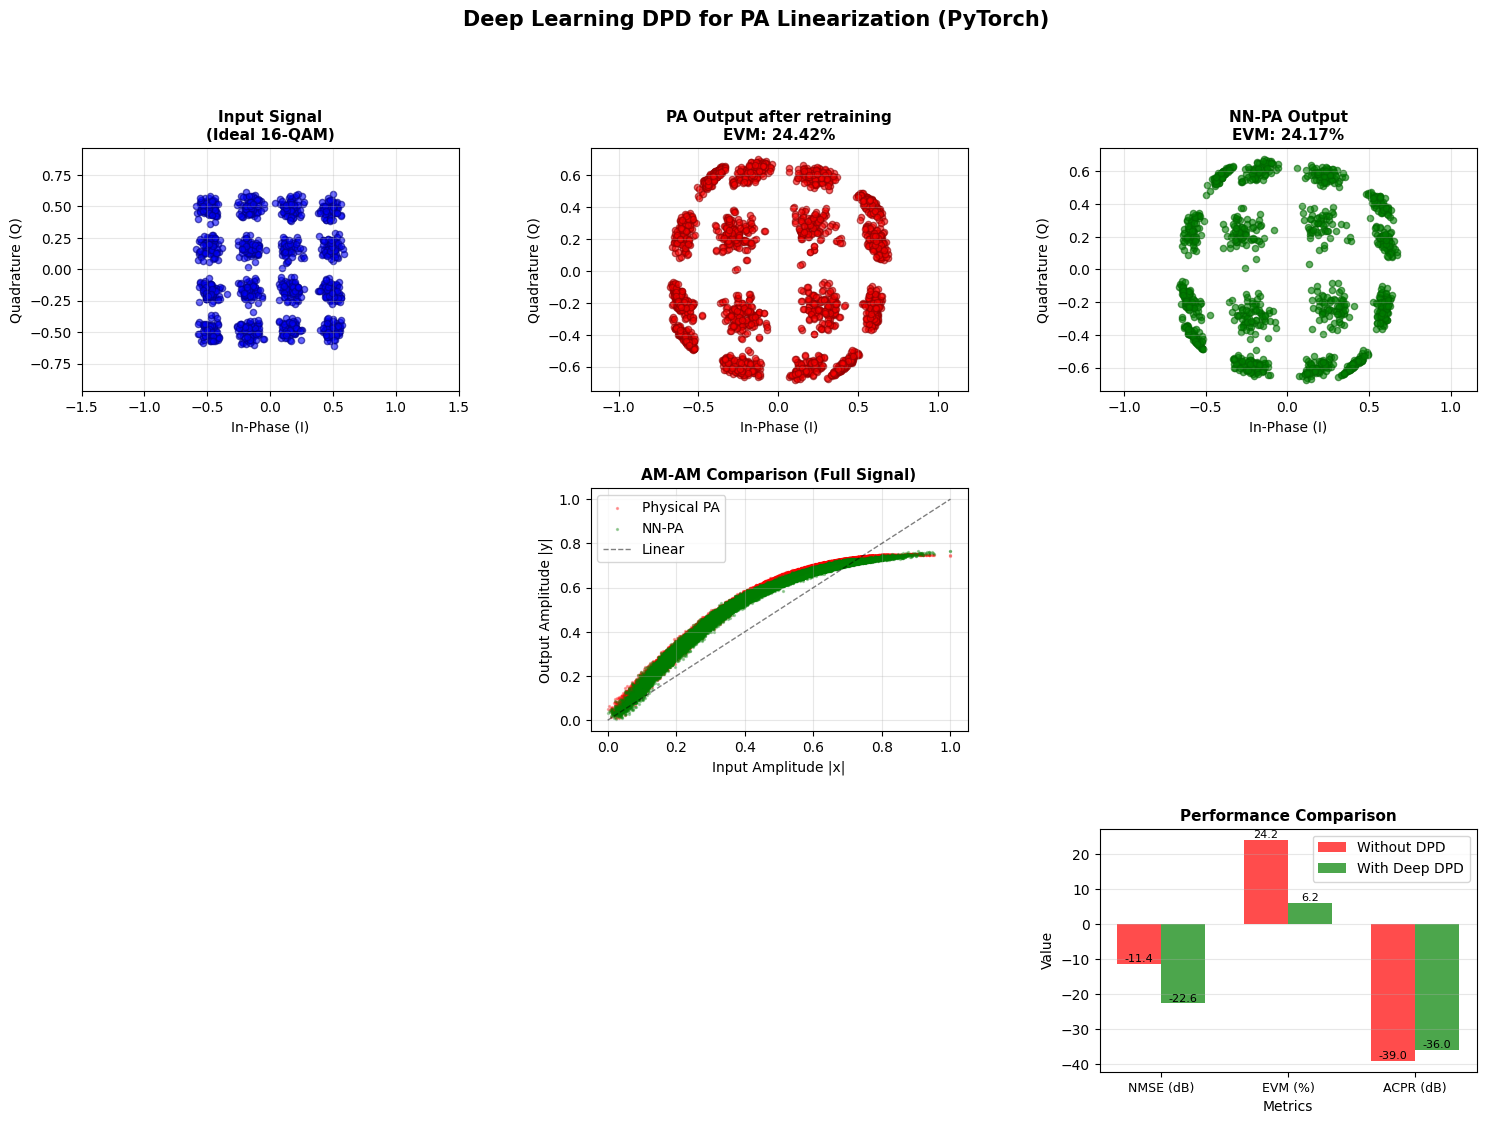


Simulation Complete!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import upfirdn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ==========================================
# 1. 16-QAM Signal Generator
# ==========================================
def generate_realistic_16qam(num_symbols, sps=8, rolloff=0.25):
    """Generates a clean 16-QAM signal with RRC pulse shaping."""
    # 1. Create 16-QAM Constellation Map (4x4 grid)
    qam_map = np.array([x + 1j*y for x in range(-3, 4, 2) for y in range(-3, 4, 2)])
    qam_map /= np.sqrt(np.mean(np.abs(qam_map)**2))  # Normalize power

    # 2. Random Symbols
    symbols_idx = np.random.randint(0, 16, num_symbols)
    symbols = qam_map[symbols_idx]

    # 3. RRC Pulse Shaping
    span = 10
    num_taps = span * sps + 1
    t = np.arange(num_taps) - (num_taps - 1) // 2

    # RRC filter design
    h_rrc = np.zeros(num_taps)
    for i in range(num_taps):
        t_val = t[i] / float(sps)

        if t_val == 0.0:
            h_rrc[i] = 1.0 - rolloff + (4.0 * rolloff / np.pi)
        elif rolloff != 0 and abs(t_val) == 1.0 / (4.0 * rolloff):
            h_rrc[i] = (rolloff / np.sqrt(2.0)) * (
                (1.0 + 2.0 / np.pi) * np.sin(np.pi / (4.0 * rolloff)) +
                (1.0 - 2.0 / np.pi) * np.cos(np.pi / (4.0 * rolloff))
            )
        else:
            numerator = np.sin(np.pi * t_val * (1.0 - rolloff)) + \
                        4.0 * rolloff * t_val * np.cos(np.pi * t_val * (1.0 + rolloff))
            denominator = np.pi * t_val * (1.0 - (4.0 * rolloff * t_val) ** 2)
            h_rrc[i] = numerator / denominator

    h_rrc = h_rrc / np.sqrt(np.sum(h_rrc ** 2))

    # Upsample and filter
    upsampled = np.zeros(len(symbols) * sps, dtype=complex)
    upsampled[::sps] = symbols
    signal = np.convolve(upsampled, h_rrc, mode='same')

    # Remove edge effects
    trim = span * sps
    if len(signal) > 2 * trim:
        signal = signal[trim:-trim]

    # Peak normalization
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        signal = signal / max_val

    return signal, symbols


# ==========================================
# 2.1 Physical PA Model
# ==========================================
class NoiselessPA:
    def __init__(self, memory_strength=0.2, saturation_level=1.2):
        self.mem_str = memory_strength
        self.sat_level = saturation_level

    def transmit(self, x):
        # Memory Effect
        x_delayed = np.roll(x, 1) * 0.5 + np.roll(x, 2) * 0.2
        x_eff = x + self.mem_str * x_delayed

        r = np.abs(x_eff)
        phi = np.angle(x_eff)

        # AM-AM (Saturation)
        gain_compression = self.sat_level * r / (1 + r**2)

        # AM-PM (Phase Twist)
        phase_distortion = -np.pi/6 * r**2

        return gain_compression * np.exp(1j * (phi + phase_distortion))

# ==========================================
# 2.2. Deep Learning PA Model (PyTorch)
# ==========================================


# =========================
# Neural Network PA Model
# =========================
class NNPA(nn.Module):
    """
    Neural network model to mimic a PA (AM-AM + AM-PM + memory)
    Input: Feature vector of past input samples (memory taps)
    Output: Complex PA output (I and Q)
    """

    def __init__(self, memory_depth=5, hidden_dims=[64,64,64,64], dropout=0.1):
        super(NNPA, self).__init__()
        self.memory_depth = memory_depth
        input_dim = 2 * (memory_depth + 1)  # real + imag for each tap



        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(dropout))
            prev_dim = h

        self.hidden = nn.Sequential(*layers)
        self.out_real = nn.Linear(prev_dim, 1)
        self.out_imag = nn.Linear(prev_dim, 1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.hidden(x)
        real = self.out_real(x)
        imag = self.out_imag(x)
        return torch.cat([real, imag], dim=1)

    def create_features(self, x):
        """Create memory polynomial features for NN-PA"""
        x = np.array(x)
        N = len(x)
        feats = []
        x_pad = np.pad(x, (self.memory_depth, 0), mode='constant')
        for i in range(N):
            window = x_pad[i:i+self.memory_depth+1][::-1]
            feats.append(np.concatenate([window.real, window.imag]))
        return np.array(feats)

# =========================
# Training function for NN-PA
# =========================
def train_nn_pa(pa_model, tx_signal, epochs=100, batch_size=128, lr=0.001, device='cpu'):
    """
    Train NN-PA using input-output data from physical PA.
    """
    scaler = StandardScaler()
    pa_model.device = device # Attach device to the model instance for later use

    # Create features for training
    X = pa_model.create_features(tx_signal)

    # Target: Output of real PA (NoiselessPA)
    pa = NoiselessPA(memory_strength=0.18, saturation_level=1.5)
    y_complex = pa.transmit(tx_signal)
    y = np.column_stack([y_complex.real, y_complex.imag])

    # Scale features
    X_scaled = scaler.fit_transform(X)
    pa_model.scaler = scaler # Attach scaler to the model instance

    # Split into train/validation (using 70/30 split)
    validation_split = 0.3
    split_idx = int(len(X_scaled) * (1 - validation_split))
    X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Convert to PyTorch tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)

    # Create data loaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(pa_model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    train_losses = []
    val_losses = []

    print(f"\nTraining NN-PA on {len(X_train)} samples...")
    for epoch in range(epochs):
        pa_model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            out = pa_model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        pa_model.eval()
        with torch.no_grad():
            val_outputs = pa_model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t).item()
            val_losses.append(val_loss)

        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

    print("NN-PA training complete.")
    return pa_model


# =========================
# Applying trained NN-PA
# =========================
def apply_nn_pa(pa_model, tx_signal):
    # 1. Feature creation (same as training)
    X = pa_model.create_features(tx_signal)

    # 2. Scale using stored scaler
    X_scaled = pa_model.scaler.transform(X)

    # 3. Torch tensor
    X_t = torch.FloatTensor(X_scaled).to(pa_model.device)

    # 4. Inference
    pa_model.eval()
    with torch.no_grad():
        out = pa_model(X_t).cpu().numpy()

    # 5. Back to complex
    return out[:, 0] + 1j * out[:, 1]

# ==========================================
# 3. Deep Learning DPD Model (PyTorch)
# ==========================================
class DeepDPD(nn.Module):
    """
    Deep Neural Network for Digital Pre-Distortion
    Architecture: Input → BatchNorm → Dense Layers with Residual Connections → Output
    """
    def __init__(self, input_dim, hidden_dims=[64,32,16], dropout=0.2):
        super(DeepDPD, self).__init__()

        self.input_bn = nn.BatchNorm1d(input_dim)

        layers = []
        prev_dim = input_dim

        for i, hidden_dim in enumerate(hidden_dims):
            # Dense block with residual connection
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        self.hidden_layers = nn.Sequential(*layers)

        # Separate heads for I and Q
        self.output_real = nn.Linear(prev_dim, 1)
        self.output_imag = nn.Linear(prev_dim, 1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.input_bn(x)
        x = self.hidden_layers(x)
        real = self.output_real(x)
        imag = self.output_imag(x)
        return torch.cat([real, imag], dim=1)

# ==========================================
# 4. DPD Trainer Class
# ==========================================
class DPDTrainer:
    def __init__(self, memory_depth=5, hidden_dims=[32,32,32,32], dropout=0.2, device='cpu'):
        self.memory_depth = memory_depth
        self.device = device
        self.scaler = StandardScaler()

        # Calculate input dimension
        input_dim = (memory_depth + 1) * 2  # Real and Imag for each memory tap

        self.model = DeepDPD(input_dim, hidden_dims, dropout).to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=10
        )

    def _create_features(self, x):
        """Create memory polynomial features"""
        N = len(x)
        feats = []
        x_pad = np.pad(x, (self.memory_depth, 0), mode='constant')
        for i in range(N):
            window = x_pad[i : i + self.memory_depth + 1][::-1]
            feats.append(np.concatenate([window.real, window.imag]))
        return np.array(feats)

    def train(self, pa_output, pa_input, epochs=100, batch_size=128, validation_split=0.2):
        """
        Train DPD using indirect learning architecture
        pa_output: Signal after PA (distorted)
        pa_input: Signal before PA (clean) - this is what we want to learn
        """
        # Create features
        X = self._create_features(pa_output)
        y = np.column_stack([pa_input.real, pa_input.imag])

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Split into train/validation
        split_idx = int(len(X_scaled) * (1 - validation_split))
        X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]

        # Convert to PyTorch tensors
        X_train_t = torch.FloatTensor(X_train).to(self.device)
        y_train_t = torch.FloatTensor(y_train).to(self.device)
        X_val_t = torch.FloatTensor(X_val).to(self.device)
        y_val_t = torch.FloatTensor(y_val).to(self.device)

        # Create data loaders
        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Training loop
        train_losses = []
        val_losses = []

        print(f"\nTraining Deep DPD Model...")
        print(f"Architecture: Input({X.shape[1]}) → Hidden{[256,128,64,32]} → Output(2)")
        print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

        for epoch in range(epochs):
            # Training
            self.model.train()
            epoch_loss = 0
            for batch_X, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(X_val_t)
                val_loss = self.criterion(val_outputs, y_val_t).item()
                val_losses.append(val_loss)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Print progress
            if (epoch + 1) % 20 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

        # Final validation score
        self.model.eval()
        with torch.no_grad():
            val_pred = self.model(X_val_t).cpu().numpy()
            val_pred_complex = val_pred[:, 0] + 1j * val_pred[:, 1]
            val_true_complex = y_val[:, 0] + 1j * y_val[:, 1]

            mse = np.mean(np.abs(val_pred_complex - val_true_complex)**2)
            nmse = mse / np.mean(np.abs(val_true_complex)**2)
            nmse_db = 10 * np.log10(nmse)

            print(f"\nDPD Training Complete!")
            print(f"Validation NMSE: {nmse_db:.2f} dB")

        return train_losses, val_losses


    def apply(self, x_desired):
        X = self._create_features(x_desired)
        X_scaled = self.scaler.transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)

        self.model.eval()
        with torch.no_grad():
            output = self.model(X_tensor).cpu().numpy()

        return output[:, 0] + 1j * output[:, 1]


# ==========================================
# 5. Performance Metrics
# ==========================================
def calculate_metrics(tx_signal, rx_signal, sps=8):
    """Calculate EVM, NMSE, and ACPR"""
    # Align phases
    avg_rot = np.exp(-1j * np.angle(np.mean(rx_signal/tx_signal)))
    rx_aligned = rx_signal * avg_rot

    # NMSE (dB)
    nmse = np.mean(np.abs(rx_aligned - tx_signal)**2) / np.mean(np.abs(tx_signal)**2)
    nmse_db = 10 * np.log10(nmse)

    # EVM (%) - at symbol rate
    tx_symbols = tx_signal[::sps]
    rx_symbols = rx_aligned[::sps]
    evm_rms = np.sqrt(np.mean(np.abs(rx_symbols - tx_symbols)**2)) / np.sqrt(np.mean(np.abs(tx_symbols)**2))
    evm_percent = evm_rms * 100

    # ACPR
    fft_signal = np.fft.fftshift(np.fft.fft(rx_aligned))
    psd = np.abs(fft_signal)**2
    N = len(psd)

    main_start = int(N * 0.3)
    main_end = int(N * 0.7)
    main_power = np.sum(psd[main_start:main_end])

    adj_lower = np.sum(psd[int(N*0.1):int(N*0.3)])
    adj_upper = np.sum(psd[int(N*0.7):int(N*0.9)])
    adj_power = adj_lower + adj_upper

    acpr_db = 10 * np.log10(adj_power / main_power)

    return {
        'NMSE_dB': nmse_db,
        'EVM_%': evm_percent,
        'ACPR_dB': acpr_db
    }

# ==========================================
# 6. Run Simulation
# ==========================================

# Setup
NUM_SYMBOLS = 4000
SPS = 8
ROLLOFF = 0.25
MEMORY_STRENGTH = 0.18
SATURATION_LEVEL = 1.5
EPOCHS = 100
BATCH_SIZE = 128

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("="*70)
print("Deep Learning DPD for PA Linearization")
print("="*70)

# print("\n[1] Generating 16-QAM signal...")
# tx_signal, tx_symbols = generate_realistic_16qam(num_symbols=NUM_SYMBOLS,
#                                                   sps=SPS, rolloff=ROLLOFF)

# print("[2] Simulating PA (without DPD)...")
# pa = NoiselessPA(memory_strength=MEMORY_STRENGTH, saturation_level=SATURATION_LEVEL)
# rx_no_dpd = pa.transmit(tx_signal)

# Calculate metrics WITHOUT DPD
# metrics_no_dpd = calculate_metrics(tx_signal, rx_no_dpd, sps=SPS)
# print(f"\n--- Performance WITHOUT DPD ---")
# print(f"NMSE: {metrics_no_dpd['NMSE_dB']:.2f} dB")
# print(f"EVM: {metrics_no_dpd['EVM_%']:.2f} %")
# print(f"ACPR: {metrics_no_dpd['ACPR_dB']:.2f} dB")




# # Train Deep DPD
# split = int(0.7 * len(tx_signal))
# print(f"\n[3] Training Deep Learning DPD...")
# dpd = DPDTrainer(memory_depth=5, hidden_dims=[128, 64, 32], dropout=0.2, device=device)
# train_losses, val_losses = dpd.train(rx_no_dpd[:split], tx_signal[:split],
#                                       epochs=EPOCHS, batch_size=BATCH_SIZE)
# "P2 Epoch {ep+1}/{ph2_epochs} Loss {epoch_loss/len(train_loader.dataset):.6e}"


# # Apply DPD and test
# print("\n[4] Applying DPD and testing...")
# tx_predistorted = dpd.apply(tx_signal)
# rx_with_dpd = pa.transmit(tx_predistorted)

# # Calculate metrics WITH DPD
# metrics_with_dpd = calculate_metrics(tx_signal, rx_with_dpd, sps=SPS)
# print(f"\n--- Performance WITH Deep DPD ---")
# print(f"NMSE: {metrics_with_dpd['NMSE_dB']:.2f} dB")
# print(f"EVM: {metrics_with_dpd['EVM_%']:.2f} %")
# print(f"ACPR: {metrics_with_dpd['ACPR_dB']:.2f} dB")

# # Improvement
# print(f"\n--- IMPROVEMENT ---")
# print(f"NMSE Improvement: {metrics_no_dpd['NMSE_dB'] - metrics_with_dpd['NMSE_dB']:.2f} dB")
# print(f"EVM Improvement: {metrics_no_dpd['EVM_%'] - metrics_with_dpd['EVM_%']:.2f} %")
# print(f"ACPR Improvement: {metrics_no_dpd['ACPR_dB'] - metrics_with_dpd['ACPR_dB']:.2f} dB")

# # ==========================================
# # 7. Visualization
# # ==========================================
# fig = plt.figure(figsize=(18, 12))
# plt.subplots_adjust(wspace=0.35, hspace=0.4)

# # Align phases
# avg_rot_no_dpd = np.exp(-1j * np.angle(np.mean(rx_no_dpd/tx_signal)))
# avg_rot_with_dpd = np.exp(-1j * np.angle(np.mean(rx_with_dpd/tx_signal)))

# # Sample at symbol rate
# tx_sampled = tx_signal[split:][::SPS]
# rx_no_dpd_sampled = (rx_no_dpd[split:] * avg_rot_no_dpd)[::SPS]
# rx_with_dpd_sampled = (rx_with_dpd[split:] * avg_rot_with_dpd)[::SPS]

# # Row 1: Constellations
# ax1 = plt.subplot(3, 3, 1)
# ax1.scatter(tx_sampled.real, tx_sampled.imag, c='blue', s=20, alpha=0.6, edgecolors='navy')
# ax1.set_title("Input Signal\n(Ideal 16-QAM)", fontsize=11, fontweight='bold')
# ax1.set_xlabel("In-Phase (I)")
# ax1.set_ylabel("Quadrature (Q)")
# ax1.grid(True, alpha=0.3)
# ax1.axis('equal')
# ax1.set_xlim(-1.5, 1.5)
# ax1.set_ylim(-1.5, 1.5)

# ax2 = plt.subplot(3, 3, 2)
# ax2.scatter(rx_no_dpd_sampled.real, rx_no_dpd_sampled.imag, c='red', s=20, alpha=0.6, edgecolors='darkred')
# ax2.set_title(f"PA Output (NO DPD)\nEVM: {metrics_no_dpd['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
# ax2.set_xlabel("In-Phase (I)")
# ax2.set_ylabel("Quadrature (Q)")
# ax2.grid(True, alpha=0.3)
# ax2.axis('equal')

# ax3 = plt.subplot(3, 3, 3)
# ax3.scatter(rx_with_dpd_sampled.real, rx_with_dpd_sampled.imag, c='green', s=20, alpha=0.6, edgecolors='darkgreen')
# ax3.set_title(f"PA Output (WITH Deep DPD)\nEVM: {metrics_with_dpd['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
# ax3.set_xlabel("In-Phase (I)")
# ax3.set_ylabel("Quadrature (Q)")
# ax3.grid(True, alpha=0.3)
# ax3.axis('equal')

# # Row 2: Training curves and AM-AM
# ax4 = plt.subplot(3, 3, 4)
# epochs_range = range(1, len(train_losses) + 1)
# ax4.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
# ax4.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
# ax4.set_xlabel('Epoch')
# ax4.set_ylabel('MSE Loss')
# ax4.set_title('DPD Training Progress', fontsize=11, fontweight='bold')
# ax4.legend()
# ax4.grid(True, alpha=0.3)
# ax4.set_yscale('log')

# ax5 = plt.subplot(3, 3, 5)
# ax5.scatter(np.abs(tx_signal[split:]), np.abs(rx_no_dpd[split:]), c='red', s=2, alpha=0.3, label='No DPD')
# ax5.scatter(np.abs(tx_signal[split:]), np.abs(rx_with_dpd[split:]), c='green', s=2, alpha=0.3, label='With DPD')
# ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='Linear')
# ax5.set_title("AM-AM Comparison", fontsize=11, fontweight='bold')
# ax5.set_xlabel("Input Amplitude |x|")
# ax5.set_ylabel("Output Amplitude |y|")
# ax5.legend()
# ax5.grid(True, alpha=0.3)

# ax6 = plt.subplot(3, 3, 6)
# ax6.scatter(np.abs(tx_signal[split:]), np.abs(tx_predistorted[split:]), c='purple', s=2, alpha=0.3)
# ax6.set_title("Deep DPD Pre-Distortion\n(Input to PA)", fontsize=11, fontweight='bold')
# ax6.set_xlabel("Desired Amplitude")
# ax6.set_ylabel("Pre-Distorted Amplitude")
# ax6.grid(True, alpha=0.3)

# # Row 3: AM-PM and Performance
# ax7 = plt.subplot(3, 3, 7)
# phase_diff_no_dpd = np.angle(rx_no_dpd[split:]) - np.angle(tx_signal[split:])
# phase_diff_no_dpd = (phase_diff_no_dpd + np.pi) % (2 * np.pi) - np.pi
# ax7.scatter(np.abs(tx_signal[split:]), phase_diff_no_dpd, c='red', s=2, alpha=0.3, label='No DPD')
# ax7.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
# ax7.set_title("AM-PM (NO DPD)", fontsize=11, fontweight='bold')
# ax7.set_xlabel("Input Amplitude |x|")
# ax7.set_ylabel("Phase Shift (rad)")
# ax7.grid(True, alpha=0.3)

# ax8 = plt.subplot(3, 3, 8)
# phase_diff_with_dpd = np.angle(rx_with_dpd[split:]) - np.angle(tx_signal[split:])
# phase_diff_with_dpd = (phase_diff_with_dpd + np.pi) % (2 * np.pi) - np.pi
# ax8.scatter(np.abs(tx_signal[split:]), phase_diff_with_dpd, c='green', s=2, alpha=0.3, label='With DPD')
# ax8.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
# ax8.set_title("AM-PM (WITH Deep DPD)", fontsize=11, fontweight='bold')
# ax8.set_xlabel("Input Amplitude |x|")
# ax8.set_ylabel("Phase Shift (rad)")
# ax8.grid(True, alpha=0.3)

# # Performance Comparison
# ax9 = plt.subplot(3, 3, 9)
# metrics_names = ['NMSE (dB)', 'EVM (%)', 'ACPR (dB)']
# no_dpd_vals = [metrics_no_dpd['NMSE_dB'], metrics_no_dpd['EVM_%'], metrics_no_dpd['ACPR_dB']]
# with_dpd_vals = [metrics_with_dpd['NMSE_dB'], metrics_with_dpd['EVM_%'], metrics_with_dpd['ACPR_dB']]

# x_pos = np.arange(len(metrics_names))
# width = 0.35

# bars1 = ax9.bar(x_pos - width/2, no_dpd_vals, width, label='Without DPD', color='red', alpha=0.7)
# bars2 = ax9.bar(x_pos + width/2, with_dpd_vals, width, label='With Deep DPD', color='green', alpha=0.7)

# ax9.set_xlabel('Metrics')
# ax9.set_ylabel('Value')
# ax9.set_title('Performance Comparison', fontsize=11, fontweight='bold')
# ax9.set_xticks(x_pos)
# ax9.set_xticklabels(metrics_names, fontsize=9)
# ax9.legend()
# ax9.grid(True, alpha=0.3, axis='y')

# for bars in [bars1, bars2]:
#     for bar in bars:
#         height = bar.get_height()
#         ax9.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{height:.1f}',
#                 ha='center', va='bottom', fontsize=8)

# plt.suptitle("Deep Learning DPD for PA Linearization (PyTorch)",
#              fontsize=15, fontweight='bold', y=0.995)
# plt.show()

# print("\n" + "="*70)
# print("Simulation Complete!")
# print("="*70)

# =========================
# Example usage
# =========================
if __name__ == "__main__":
    NUM_SYMBOLS = 4000
    SPS = 8
    ROLLOFF = 0.25
    split=int(0.7*NUM_SYMBOLS)

    # Generate 16-QAM signal (reuse your function)
    tx_signal, tx_symbols = generate_realistic_16qam(NUM_SYMBOLS, sps=SPS, rolloff=ROLLOFF)

    # Initialize NN-PA and move to device
    nn_pa = NNPA(memory_depth=2, hidden_dims=[64,64,64,64]).to(device)

    # Train NN-PA
    nn_pa = train_nn_pa(nn_pa, tx_signal, epochs=100, device=device)

    # Test NN-PA output
    rx_nn_pa = apply_nn_pa(nn_pa, tx_signal)

    # Compare NMSE vs physical PA
    pa = NoiselessPA(memory_strength=0.18, saturation_level=1.5)
    rx_real_pa = pa.transmit(tx_signal)
    nmse = np.mean(np.abs(rx_nn_pa - rx_real_pa)**2) / np.mean(np.abs(rx_real_pa)**2)
    nmse_db = 10*np.log10(nmse)
    print(f"NN-PA NMSE vs real PA: {nmse_db:.2f} dB")



    # Calculate metrics PHYSICAL PA
    metrics_PHYSICAL_PA = calculate_metrics(tx_signal, rx_real_pa, sps=SPS)
    print(f"\n--- Performance Physical PA ---") # Changed title
    print(f"NMSE: {metrics_PHYSICAL_PA['NMSE_dB']:.2f} dB")
    print(f"EVM: {metrics_PHYSICAL_PA['EVM_%']:.2f} %")
    print(f"ACPR: {metrics_PHYSICAL_PA['ACPR_dB']:.2f} dB")

    # Calculate metric_nn_PA
    metric_nn_PA = calculate_metrics(tx_signal, rx_nn_pa, sps=SPS)
    print(f"\n--- Performance NN-PA ---") # Changed title
    print(f"NMSE: {metric_nn_PA ['NMSE_dB']:.2f} dB")
    print(f"EVM: {metric_nn_PA['EVM_%']:.2f} %")
    print(f"ACPR: {metric_nn_PA['ACPR_dB']:.2f} dB")



    # Train Deep DPD
    split = int(0.7 * len(tx_signal))
    print(f"\n[3] Training Deep Learning DPD...")
    dpd = DPDTrainer(memory_depth=5, hidden_dims=[128, 64, 32], dropout=0.2, device=device)
    train_losses, val_losses = dpd.train(rx_nn_pa[:split], tx_signal[:split],
                                          epochs=EPOCHS, batch_size=BATCH_SIZE)
    "P2 Epoch {ep+1}/{ph2_epochs} Loss {epoch_loss/len(train_loader.dataset):.6e}"



    # Apply DPD and test
    print("\n[4] Applying DPD and testing...")
    tx_predistorted = dpd.apply(tx_signal)

    rx_with_dpd =apply_nn_pa(nn_pa,tx_predistorted)

    # Calculate metrics WITH DPD
    metrics_with_dpd = calculate_metrics(tx_signal, rx_with_dpd, sps=SPS)
    print(f"\n--- Performance WITH Deep DPD ---")
    print(f"NMSE: {metrics_with_dpd['NMSE_dB']:.2f} dB")
    print(f"EVM: {metrics_with_dpd['EVM_%']:.2f} %")
    print(f"ACPR: {metrics_with_dpd['ACPR_dB']:.2f} dB")

    nn_pa=train_nn_pa(nn_pa, tx_signal, epochs=100, device=device)
    rx_retrained_nn_pa = apply_nn_pa(nn_pa, tx_signal)


    # Calculate metric_nn_PA
    metric_rx_retrained_nn_pa = calculate_metrics(tx_signal, rx_retrained_nn_pa, sps=SPS)
    print(f"\n--- Performance rx_retrained_nn_pa  ---") # Changed title
    print(f"NMSE: {metric_rx_retrained_nn_pa ['NMSE_dB']:.2f} dB")
    print(f"EVM: {metric_rx_retrained_nn_pa['EVM_%']:.2f} %")
    print(f"ACPR: {metric_rx_retrained_nn_pa['ACPR_dB']:.2f} dB")






    # ==========================================
    # 7. Visualization for NN-PA comparison
    # ==========================================
    fig = plt.figure(figsize=(18, 12)) # Initialize figure
    plt.subplots_adjust(wspace=0.35, hspace=0.4)

    # Align phases for plotting
    avg_rot_real_pa = np.exp(-1j * np.angle(np.mean(rx_real_pa/tx_signal)))
    avg_rot_nn_pa = np.exp(-1j * np.angle(np.mean(rx_nn_pa/tx_signal)))

    # Sample at symbol rate for constellations (using the test part of the signal)
    tx_sampled = tx_signal[split:][::SPS]
    rx_real_pa_sampled = (rx_real_pa[split:] * avg_rot_real_pa)[::SPS]
    rx_nn_pa_sampled = (rx_nn_pa[split:] * avg_rot_nn_pa)[::SPS]
    rx_retrained_nn_pa_sampled = (rx_retrained_nn_pa[split:] * avg_rot_nn_pa)[::SPS]

    # Row 1: Constellations
    ax1 = plt.subplot(3, 3, 1) # Renamed from ax2 for clarity, since it's the first plot
    ax1.scatter(tx_sampled.real, tx_sampled.imag, c='blue', s=20, alpha=0.6, edgecolors='navy')
    ax1.set_title("Input Signal\n(Ideal 16-QAM)", fontsize=11, fontweight='bold')
    ax1.set_xlabel("In-Phase (I)")
    ax1.set_ylabel("Quadrature (Q)")
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)


    ax2 = plt.subplot(3, 3, 2)
    ax2.scatter(rx_real_pa_sampled.real, rx_real_pa_sampled.imag, c='red', s=20, alpha=0.6, edgecolors='darkred')
    ax2.set_title(f"Physical PA Output\nEVM: {metrics_PHYSICAL_PA['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
    ax2.set_xlabel("In-Phase (I)")
    ax2.set_ylabel("Quadrature (Q)")
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')

    ax22 = plt.subplot(3, 3, 2)
    ax22.scatter(rx_retrained_nn_pa_sampled.real, rx_retrained_nn_pa_sampled.imag, c='red', s=20, alpha=0.6, edgecolors='darkred')
    ax22.set_title(f"PA Output after retraining\nEVM: {metric_rx_retrained_nn_pa['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
    ax22.set_xlabel("In-Phase (I)")
    ax22.set_ylabel("Quadrature (Q)")
    ax22.grid(True, alpha=0.3)
    ax22.axis('equal')

    ax3 = plt.subplot(3, 3, 3)
    ax3.scatter(rx_nn_pa_sampled.real, rx_nn_pa_sampled.imag, c='green', s=20, alpha=0.6, edgecolors='darkgreen')
    ax3.set_title(f"NN-PA Output\nEVM: {metric_nn_PA['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
    ax3.set_xlabel("In-Phase (I)")
    ax3.set_ylabel("Quadrature (Q)")
    ax3.grid(True, alpha=0.3)
    ax3.axis('equal')

    # Row 2: AM-AM Comparison (full signal, not just split)
    ax5 = plt.subplot(3, 3, 5)
    ax5.scatter(np.abs(tx_signal), np.abs(rx_real_pa), c='red', s=2, alpha=0.3, label='Physical PA')
    ax5.scatter(np.abs(tx_signal), np.abs(rx_nn_pa), c='green', s=2, alpha=0.3, label='NN-PA')
    ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='Linear')
    ax5.set_title("AM-AM Comparison (Full Signal)", fontsize=11, fontweight='bold')
    ax5.set_xlabel("Input Amplitude |x|")
    ax5.set_ylabel("Output Amplitude |y|")
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Performance Comparison
    ax9 = plt.subplot(3, 3, 9)
    metrics_names = ['NMSE (dB)', 'EVM (%)', 'ACPR (dB)']
    no_dpd_vals = [metric_nn_PA['NMSE_dB'], metric_nn_PA['EVM_%'], metric_nn_PA['ACPR_dB']]
    with_dpd_vals = [metrics_with_dpd['NMSE_dB'], metrics_with_dpd['EVM_%'], metrics_with_dpd['ACPR_dB']]

    x_pos = np.arange(len(metrics_names))
    width = 0.35

    bars1 = ax9.bar(x_pos - width/2, no_dpd_vals, width, label='Without DPD', color='red', alpha=0.7)
    bars2 = ax9.bar(x_pos + width/2, with_dpd_vals, width, label='With Deep DPD', color='green', alpha=0.7)

    ax9.set_xlabel('Metrics')
    ax9.set_ylabel('Value')
    ax9.set_title('Performance Comparison', fontsize=11, fontweight='bold')
    ax9.set_xticks(x_pos)
    ax9.set_xticklabels(metrics_names, fontsize=9)
    ax9.legend()
    ax9.grid(True, alpha=0.3, axis='y')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax9.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=8)

    plt.suptitle("Deep Learning DPD for PA Linearization (PyTorch)",
                 fontsize=15, fontweight='bold', y=0.995)
    plt.show()

    print("\n" + "="*70)
    print("Simulation Complete!")
    print("="*70)


    #TEST DATA
    # tx_test, _ = generate_realistic_16qam(4000, sps=8, rolloff=0.25)


    # # Initialize NN-PA and move to device
    # nn_pa = NNPA(memory_depth=2, hidden_dims=[32,32,32,32]).to(device)

    # # Train NN-PA
    # nn_pa = train_nn_pa(nn_pa, tx_test, epochs=100, device=device)

    # rx_nn_test = apply_nn_pa(nn_pa, tx_test)
    # pa= NoiselessPA(memory_strength=0.18, saturation_level=1.5)
    # rx_real_test = pa.transmit(tx_test)

    # nmse_test = np.mean(np.abs(rx_nn_test - rx_real_test)**2) / np.mean(np.abs(rx_real_test)**2)
    # print(10*np.log10(nmse_test))
